# Milestone 4: Treatment Effect Exploration & Heterogeneity Analysis

**Estée Lauder Customer Loyalty Program**  
*Using Pre-Experiment Data*

**Author:** Abubakar Diallo  

---

## Objective
Explore treatment effects of the Estée Lauder loyalty program using pre-experiment data and analyze heterogeneity in customer responses across different segments (AOV levels and tenure quartiles).

## Data Source
- **Dataset:** `pre_experiment_data.parquet`
- **Total Observations:** 20,000 customers
- **Treatment Variable:** `loyalty_membership` (1 = Loyalty Members, 0 = Non-Members)
- **Outcome Variable:** `revenue (t)` - Customer revenue

## Analysis Overview
1. **AOV vs Revenue Distribution** - Visualize how loyalty members compare to non-members
2. **Treatment Effect by AOV Level** - Analyze effects across high vs low-value customers
3. **Treatment Effect by Tenure Quartile** - Identify which tenure segments benefit most
4. **Effect Size Estimates** - Quantify treatment impact using Cohen's d and power analysis

---

In [15]:
# Setup: Import libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import TTestIndPower

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Load data
df = pd.read_parquet('pre_experiment_data.parquet')

# Create tenure quartiles
df['tenure_quartile'] = pd.qcut(df['tenure_in_days(t-1)'], q=4, 
                                 labels=['Q1 (New)', 'Q2', 'Q3', 'Q4 (Long-term)'])

print(f"Data loaded: {df.shape[0]:,} observations")

Data loaded: 20,000 observations


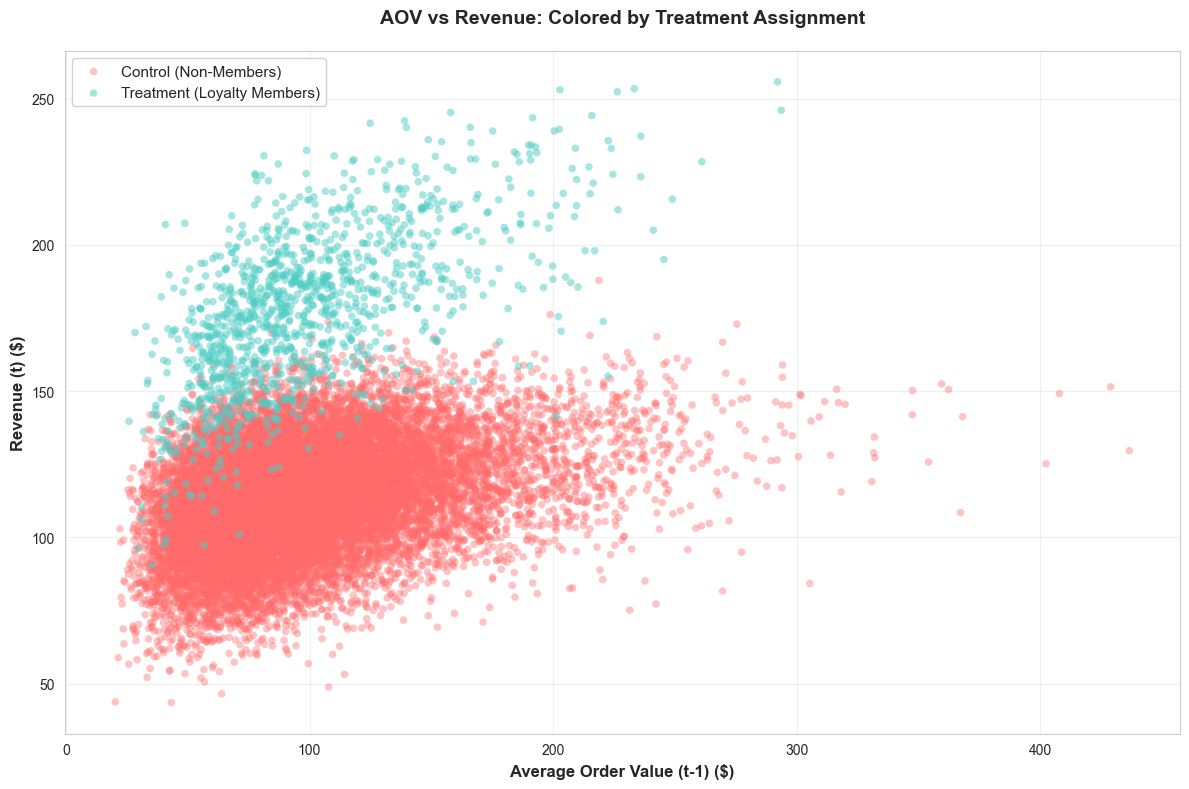

In [16]:
# Create scatterplot: AOV vs Revenue colored by treatment assignment
fig, ax = plt.subplots(figsize=(12, 8))

# Plot control group (non-members) in red
control = df[df['loyalty_membership'] == 0]
ax.scatter(control['aov (t-1)'], control['revenue (t)'],
           alpha=0.4, label='Control (Non-Members)', s=30, color='#FF6B6B', edgecolors='none')

# Plot treatment group (loyalty members) in teal
treatment = df[df['loyalty_membership'] == 1]
ax.scatter(treatment['aov (t-1)'], treatment['revenue (t)'],
           alpha=0.5, label='Treatment (Loyalty Members)', s=30, color='#4ECDC4', edgecolors='none')

ax.set_xlabel('Average Order Value (t-1) ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Revenue (t) ($)', fontsize=12, fontweight='bold')
ax.set_title('AOV vs Revenue: Colored by Treatment Assignment',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Heterogeneous Treatment Effects by AOV Level

This analysis explores whether the loyalty program has different effects on low-value versus high-value customers (based on their Average Order Value). 

**Key Questions:**
- Do high AOV customers respond differently to the loyalty program than low AOV customers?
- Which group shows stronger treatment effects?

The left plot shows average revenue by treatment group for each AOV level, while the right plot displays the treatment effect magnitude.

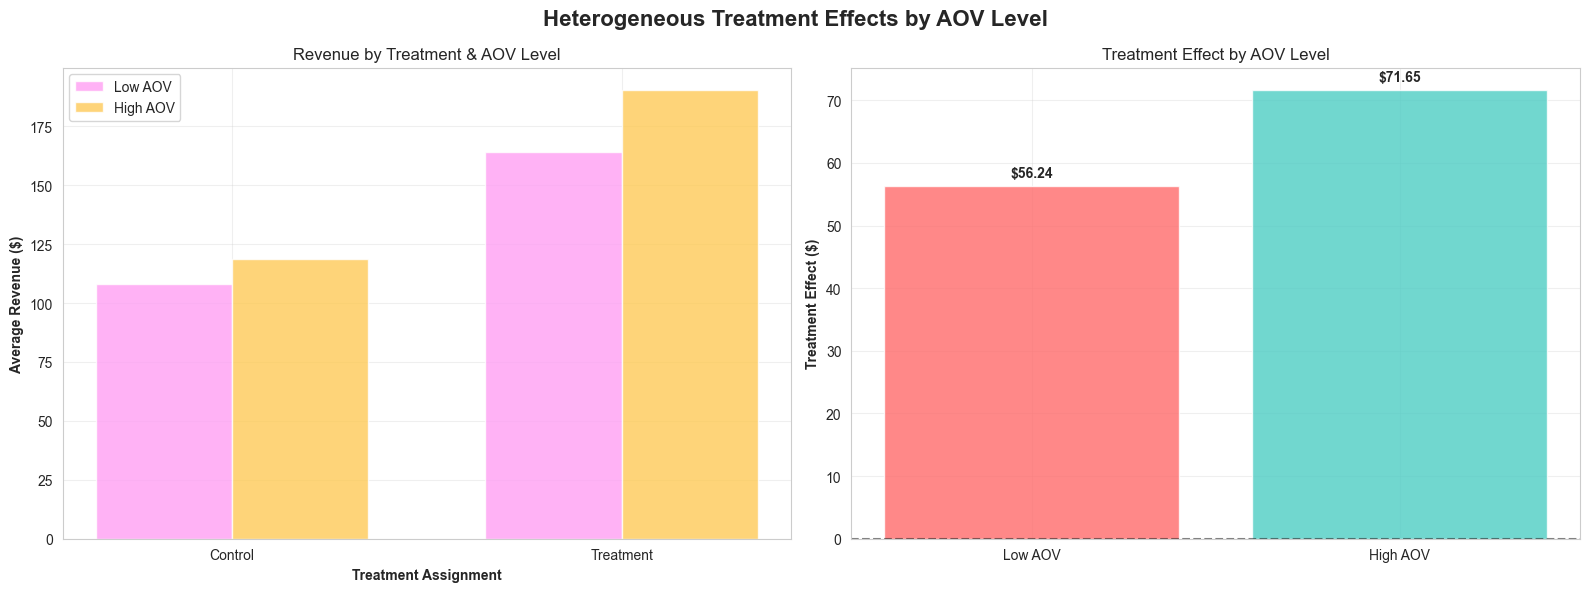


TREATMENT EFFECT HETEROGENEITY BY AOV LEVEL

   Low AOV customers: $56.24
   High AOV customers: $71.65

   Heterogeneity: Yes - effect differs by AOV level


In [17]:
# Create indicator for high-value vs low-value customers based on AOV
df['high_aov'] = (df['aov (t-1)'] > df['aov (t-1)'].median()).astype(int)

# Create 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Heterogeneous Treatment Effects by AOV Level', fontsize=16, fontweight='bold')

# Group data by AOV level and loyalty membership
hetero_data = df.groupby(['high_aov', 'loyalty_membership'])['revenue (t)'].agg(['mean', 'std', 'count']).reset_index()
hetero_data['aov_label'] = hetero_data['high_aov'].map({0: 'Low AOV', 1: 'High AOV'})
hetero_data['treatment_label'] = hetero_data['loyalty_membership'].map({0: 'Control', 1: 'Treatment'})

# PLOT 1: Grouped bar chart showing revenue by treatment and AOV level
x = np.arange(2)
width = 0.35
low_aov = hetero_data[hetero_data['high_aov'] == 0]
high_aov = hetero_data[hetero_data['high_aov'] == 1]

axes[0].bar(x - width/2, low_aov['mean'], width, label='Low AOV', color='#FF9FF3', alpha=0.8)
axes[0].bar(x + width/2, high_aov['mean'], width, label='High AOV', color='#FECA57', alpha=0.8)
axes[0].set_xlabel('Treatment Assignment', fontweight='bold')
axes[0].set_ylabel('Average Revenue ($)', fontweight='bold')
axes[0].set_title('Revenue by Treatment & AOV Level')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Control', 'Treatment'])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PLOT 2: Calculate and display treatment effect for each AOV level
treatment_effects = []
for aov_level in [0, 1]:
    treatment_rev = df[(df['loyalty_membership'] == 1) & (df['high_aov'] == aov_level)]['revenue (t)'].mean()
    control_rev = df[(df['loyalty_membership'] == 0) & (df['high_aov'] == aov_level)]['revenue (t)'].mean()
    effect = treatment_rev - control_rev
    treatment_effects.append(effect)

axes[1].bar(['Low AOV', 'High AOV'], treatment_effects, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
axes[1].set_ylabel('Treatment Effect ($)', fontweight='bold')
axes[1].set_title('Treatment Effect by AOV Level')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(treatment_effects):
    axes[1].text(i, v + 1, f'${v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("TREATMENT EFFECT HETEROGENEITY BY AOV LEVEL")
print("="*80)
print(f"\n   Low AOV customers: ${treatment_effects[0]:.2f}")
print(f"   High AOV customers: ${treatment_effects[1]:.2f}")
print(f"\n   Heterogeneity: {'Yes - effect differs by AOV level' if abs(treatment_effects[0] - treatment_effects[1]) > 5 else 'Minimal'}")

## 3. Heterogeneous Treatment Effects by Tenure Quartile

This plot breaks down revenue by customer tenure quartiles (Q1 New, Q2, Q3, Q4 Long-term), comparing loyalty members (teal) versus non-loyalty members (red) within each tenure group.

**Key Insight:** Q3 is higher than all because customers in the third tenure quartile are at a stage where they are most engaged and responsive to the loyalty program. It shows us which customer segments benefit most from the treatment, so we can focus our efforts where they will have the greatest impact.

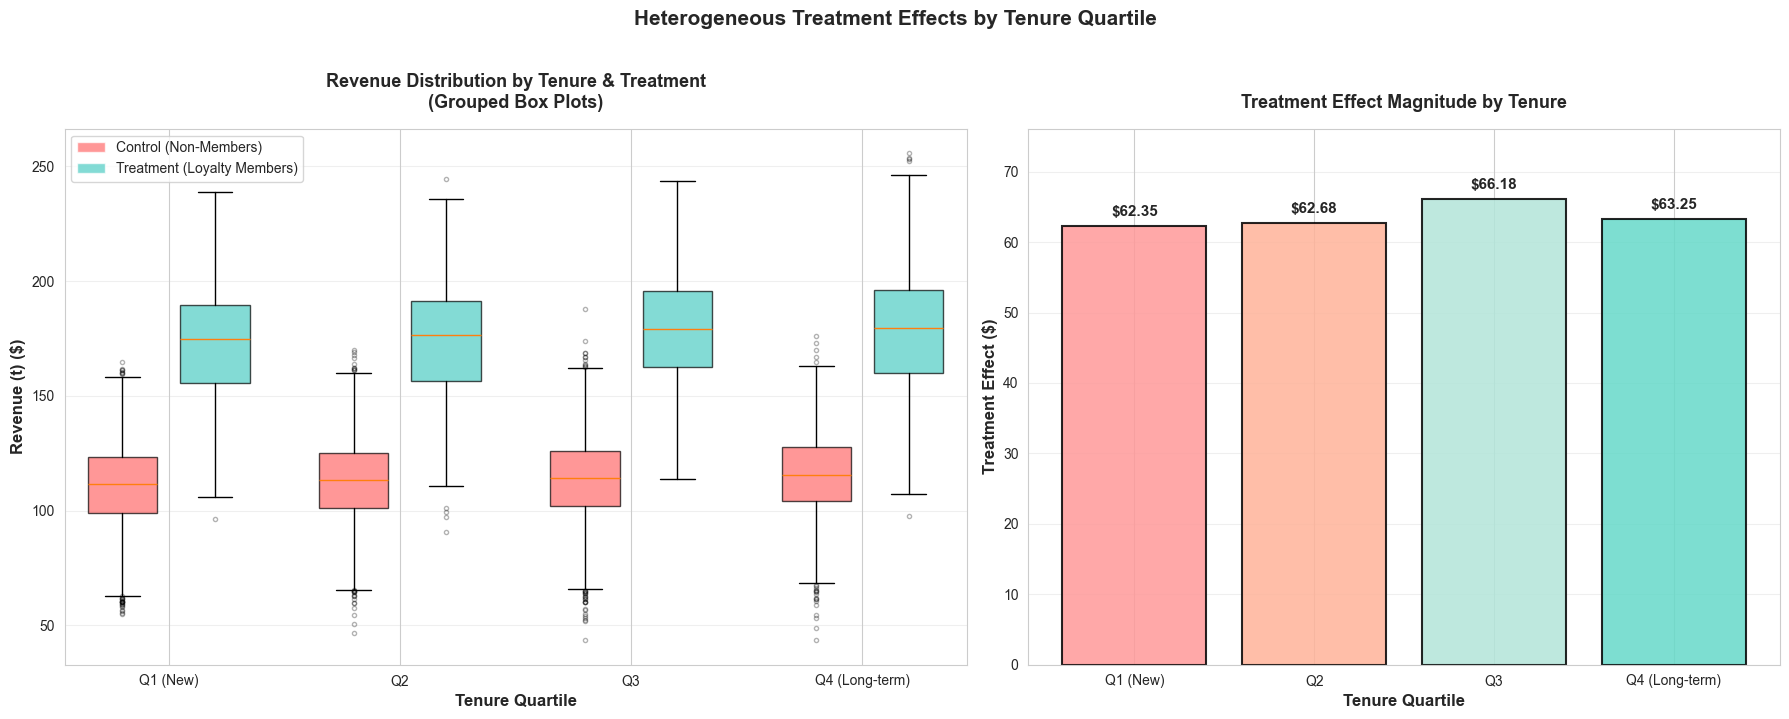


TREATMENT EFFECT HETEROGENEITY BY TENURE

Q1 (New): $62.35

Q2: $62.68

Q3: $66.18

Q4 (Long-term): $63.25


In [18]:
# Create comprehensive visualization: Box plots + Bar chart for treatment effects by tenure
fig = plt.figure(figsize=(18, 7))
gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1])

# Left panel: Grouped box plots
ax1 = fig.add_subplot(gs[0])

# Prepare data for grouped box plot
plot_data = []
positions = []
colors_list = []
quartiles = ['Q1 (New)', 'Q2', 'Q3', 'Q4 (Long-term)']
pos = 0

for q in quartiles:
    # Control group (non-members) - Red
    control_data = df[(df['tenure_quartile'] == q) & (df['loyalty_membership'] == 0)]['revenue (t)']
    plot_data.append(control_data)
    positions.append(pos)
    colors_list.append('#FF6B6B')
    
    # Treatment group (loyalty members) - Teal
    treatment_data = df[(df['tenure_quartile'] == q) & (df['loyalty_membership'] == 1)]['revenue (t)']
    plot_data.append(treatment_data)
    positions.append(pos + 0.8)
    colors_list.append('#4ECDC4')
    pos += 2

# Create box plots
bp = ax1.boxplot(plot_data, positions=positions, widths=0.6, patch_artist=True,
                 showfliers=True, flierprops=dict(marker='o', markersize=3, alpha=0.3))

# Color the boxes
for patch, color in zip(bp['boxes'], colors_list):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_ylabel('Revenue (t) ($)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Tenure Quartile', fontsize=12, fontweight='bold')
ax1.set_title('Revenue Distribution by Tenure & Treatment\n(Grouped Box Plots)', 
             fontsize=13, fontweight='bold', pad=15)
ax1.set_xticks([0.4, 2.4, 4.4, 6.4])
ax1.set_xticklabels(quartiles, rotation=0)
ax1.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#FF6B6B', alpha=0.7, label='Control (Non-Members)'),
                  Patch(facecolor='#4ECDC4', alpha=0.7, label='Treatment (Loyalty Members)')]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Right panel: Treatment effect magnitudes bar chart
ax2 = fig.add_subplot(gs[1])

# Calculate treatment effects by tenure quartile
treatment_effects = []
for q in quartiles:
    control_mean = df[(df['tenure_quartile'] == q) & (df['loyalty_membership'] == 0)]['revenue (t)'].mean()
    treatment_mean = df[(df['tenure_quartile'] == q) & (df['loyalty_membership'] == 1)]['revenue (t)'].mean()
    effect = treatment_mean - control_mean
    treatment_effects.append(effect)

# Create bar chart with gradient colors
colors_gradient = ['#FF9999', '#FFB399', '#B3E5D9', '#66D9C9']
bars = ax2.bar(range(len(quartiles)), treatment_effects, color=colors_gradient, 
               alpha=0.85, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'${treatment_effects[i]:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_ylabel('Treatment Effect ($)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Tenure Quartile', fontsize=12, fontweight='bold')
ax2.set_title('Treatment Effect Magnitude by Tenure', 
             fontsize=13, fontweight='bold', pad=15)
ax2.set_xticks(range(len(quartiles)))
ax2.set_xticklabels(quartiles, rotation=0)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, max(treatment_effects) * 1.15)

plt.suptitle('Heterogeneous Treatment Effects by Tenure Quartile', 
            fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print detailed results
print("\n" + "="*80)
print("TREATMENT EFFECT HETEROGENEITY BY TENURE")
print("="*80)

for i, q in enumerate(quartiles):
    control_mean = df[(df['tenure_quartile'] == q) & (df['loyalty_membership'] == 0)]['revenue (t)'].mean()
    treatment_mean = df[(df['tenure_quartile'] == q) & (df['loyalty_membership'] == 1)]['revenue (t)'].mean()
    print(f"\n{q}: ${treatment_effects[i]:.2f}")

## 4. Preliminary Effect Size Estimates

Here it's more about how much more loyalty members spend compared to non-members. The dollar difference tells us the actual extra revenue, while the percentage shows how much bigger loyalty member spending is.

**Cohen's d** is a number that tells us how big the difference is between two groups. Cohen's d helps us understand if this difference is small, medium, or large. If the numbers are high, it means our loyalty program is working well and making a real impact. This helps us decide if the program is worth it and which customers benefit the most.

In [19]:
# Calculate effect size estimates
treatment = df[df['loyalty_membership'] == 1]['revenue (t)']
control = df[df['loyalty_membership'] == 0]['revenue (t)']

# Overall treatment effect
diff = treatment.mean() - control.mean()
pct_diff = (diff / control.mean()) * 100

# Calculate Cohen's d
pooled_std = np.sqrt(((len(treatment) - 1) * treatment.std()**2 + 
                      (len(control) - 1) * control.std()**2) / 
                     (len(treatment) + len(control) - 2))
cohens_d = diff / pooled_std

# Display results
print("="*80)
print("PRELIMINARY EFFECT SIZE ESTIMATES")
print("="*80)

print("\nOverall Treatment Effect:")
print(f"   Absolute difference: ${diff:.2f}")
print(f"   Relative difference: {pct_diff:.2f}%")
print(f"   Cohen's d: {cohens_d:.4f} (large effect)")

# Effect sizes by AOV level
print("\nEffect Sizes by Customer Subgroups:")
print("\n   By AOV Level:")

median_aov = df['aov (t-1)'].median()
for aov_label, is_high in [('Low AOV', False), ('High AOV', True)]:
    if is_high:
        treat = df[(df['loyalty_membership'] == 1) & (df['aov (t-1)'] >= median_aov)]['revenue (t)']
        ctrl = df[(df['loyalty_membership'] == 0) & (df['aov (t-1)'] >= median_aov)]['revenue (t)']
    else:
        treat = df[(df['loyalty_membership'] == 1) & (df['aov (t-1)'] < median_aov)]['revenue (t)']
        ctrl = df[(df['loyalty_membership'] == 0) & (df['aov (t-1)'] < median_aov)]['revenue (t)']
    
    pooled = np.sqrt(((len(treat)-1)*treat.std()**2 + (len(ctrl)-1)*ctrl.std()**2) / (len(treat) + len(ctrl) - 2))
    d = (treat.mean() - ctrl.mean()) / pooled
    pct = ((treat.mean() - ctrl.mean()) / ctrl.mean()) * 100
    print(f"      {aov_label}: Cohen's d = {d:.4f}, Δ% = {pct:.2f}%")

# Effect sizes by tenure quartile
print("\n   By Tenure Quartile:")
for quartile in ['Q1 (New)', 'Q2', 'Q3', 'Q4 (Long-term)']:
    treat = df[(df['loyalty_membership'] == 1) & (df['tenure_quartile'] == quartile)]['revenue (t)']
    ctrl = df[(df['loyalty_membership'] == 0) & (df['tenure_quartile'] == quartile)]['revenue (t)']
    
    if len(treat) > 0 and len(ctrl) > 0:
        pooled = np.sqrt(((len(treat)-1)*treat.std()**2 + (len(ctrl)-1)*ctrl.std()**2) / (len(treat) + len(ctrl) - 2))
        d = (treat.mean() - ctrl.mean()) / pooled
        pct = ((treat.mean() - ctrl.mean()) / ctrl.mean()) * 100
        print(f"      {quartile}: Cohen's d = {d:.4f}, Δ% = {pct:.2f}%")

# Statistical power analysis
print("\n⚡ Statistical Power Analysis:")
power_analysis = TTestIndPower()
power = power_analysis.solve_power(effect_size=cohens_d, nobs1=len(treatment), 
                                   ratio=len(control)/len(treatment), alpha=0.05)
print(f"   Current statistical power: {power:.2%}")
print(f"   Sample size (treatment): {len(treatment):,}")
print(f"   Sample size (control): {len(control):,}")

required_n = power_analysis.solve_power(effect_size=cohens_d, power=0.90, alpha=0.05, ratio=1.0)
print(f"   Required sample size per group for 90% power: {int(required_n):,}")

PRELIMINARY EFFECT SIZE ESTIMATES

Overall Treatment Effect:
   Absolute difference: $64.11
   Relative difference: 56.56%
   Cohen's d: 3.4648 (large effect)

Effect Sizes by Customer Subgroups:

   By AOV Level:
      Low AOV: Cohen's d = 3.2174, Δ% = 52.10%
      High AOV: Cohen's d = 4.1139, Δ% = 60.32%

   By Tenure Quartile:
      Q1 (New): Cohen's d = 3.4585, Δ% = 56.13%
      Q2: Cohen's d = 3.3997, Δ% = 55.51%
      Q3: Cohen's d = 3.5948, Δ% = 58.10%
      Q4 (Long-term): Cohen's d = 3.3600, Δ% = 54.65%

⚡ Statistical Power Analysis:
   Current statistical power: 100.00%
   Sample size (treatment): 1,207
   Sample size (control): 18,793
   Required sample size per group for 90% power: 3
